# Boundary Layer Cross-sections

This notebook plots the temperature conditions of the boundary layer, as a function of the x-coordinate and the distance from the ice shelf, for each model at the end of the Ocean0, Ocean1 and Ocean2 runs.

Dave Gwyther

still WIP. adding more details

**Issues**: 
- How far in the x-direction should we focus on?

In [2]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm

from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

Models: 
```
COCO   MITgcm-BAS          MITgcm-JPL  MOM6_SIGMA_ZSTAR  NEMO-CNRS      POP2x
FVCOM  MITgcm_BAS_Coupled  MOM6        MPAS-Ocean        NEMO-UKESM1is  ROMS-UTAS
```

In [3]:
## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)

def get_labels(expt):
    '''
    Get labels of experiments
    Make some modifications to names
    '''
    labels = []
    for fileIndex in range(len(expt)):
        fileName = expt[fileIndex]
        baseName = os.path.basename(basedrive +fileName)
        modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        if "COM" in fileName:
            #make edits to COM names
            if "MOM6" in fileName:
                if "SIGMA_ZSTAR" not in fileName:
                    modelName = modelName + '-LAYER'
            elif "ROMS" in fileName:
                modelName = "ROMS"
        elif "TYP" in fileName:
            # make edits to COM names
            if "MOM6" in fileName:
                modelName = modelName + '-LAYER'
            elif "CNRS" in fileName:
                if "TYPa" in fileName:
                    modelName = modelName + '-TYPa'
                elif "TYPb" in fileName:
                    modelName = modelName + '-TYPb'
            elif "tides" in fileName:
                modelName = "ROMS-tides"
            elif "ROMS" in fileName:
                modelName = "ROMS"
        labels.append(modelName.strip('V3').replace(" ", "-"))
    return labels


In [4]:
#Type of vertical coordinate
vert_coord_type = ['s',r'$\rho$','z/s ALE','z','z','z','z','s','s']


# Ocean1 TYP

no time dimension in  FVCOM  ice draft
CHECK is this the correct transect location?
no time dimension in  MOM6-LAYER  ice draft
CHECK is this the correct transect location?
no time dimension in  MPAS-Ocean  ice draft
CHECK is this the correct transect location?
no time dimension in  NEMO-CNRS-TYPa  ice draft
CHECK is this the correct transect location?
This model  NEMO-CNRS/Ocean0-2 TYP/TYPa/Ocean1_TYPa_NEMO-CNRS.nc  has an inverted iceDraft - flipping to match others
no time dimension in  NEMO-CNRS-TYPb  ice draft
CHECK is this the correct transect location?
This model  NEMO-CNRS/Ocean0-2 TYP/TYPb/Ocean1_TYPb_NEMO-CNRS.nc  has an inverted iceDraft - flipping to match others
no time dimension in  NEMO-UKESM1is  ice draft
CHECK is this the correct transect location?
This model  NEMO-UKESM1is/Ocean0-2 TYP/Ocean1_TYP_NEMO-UKESM1is.nc  has an inverted iceDraft - flipping to match others
no time dimension in  POP2x  ice draft
CHECK is this the correct transect location?
removing time dimens

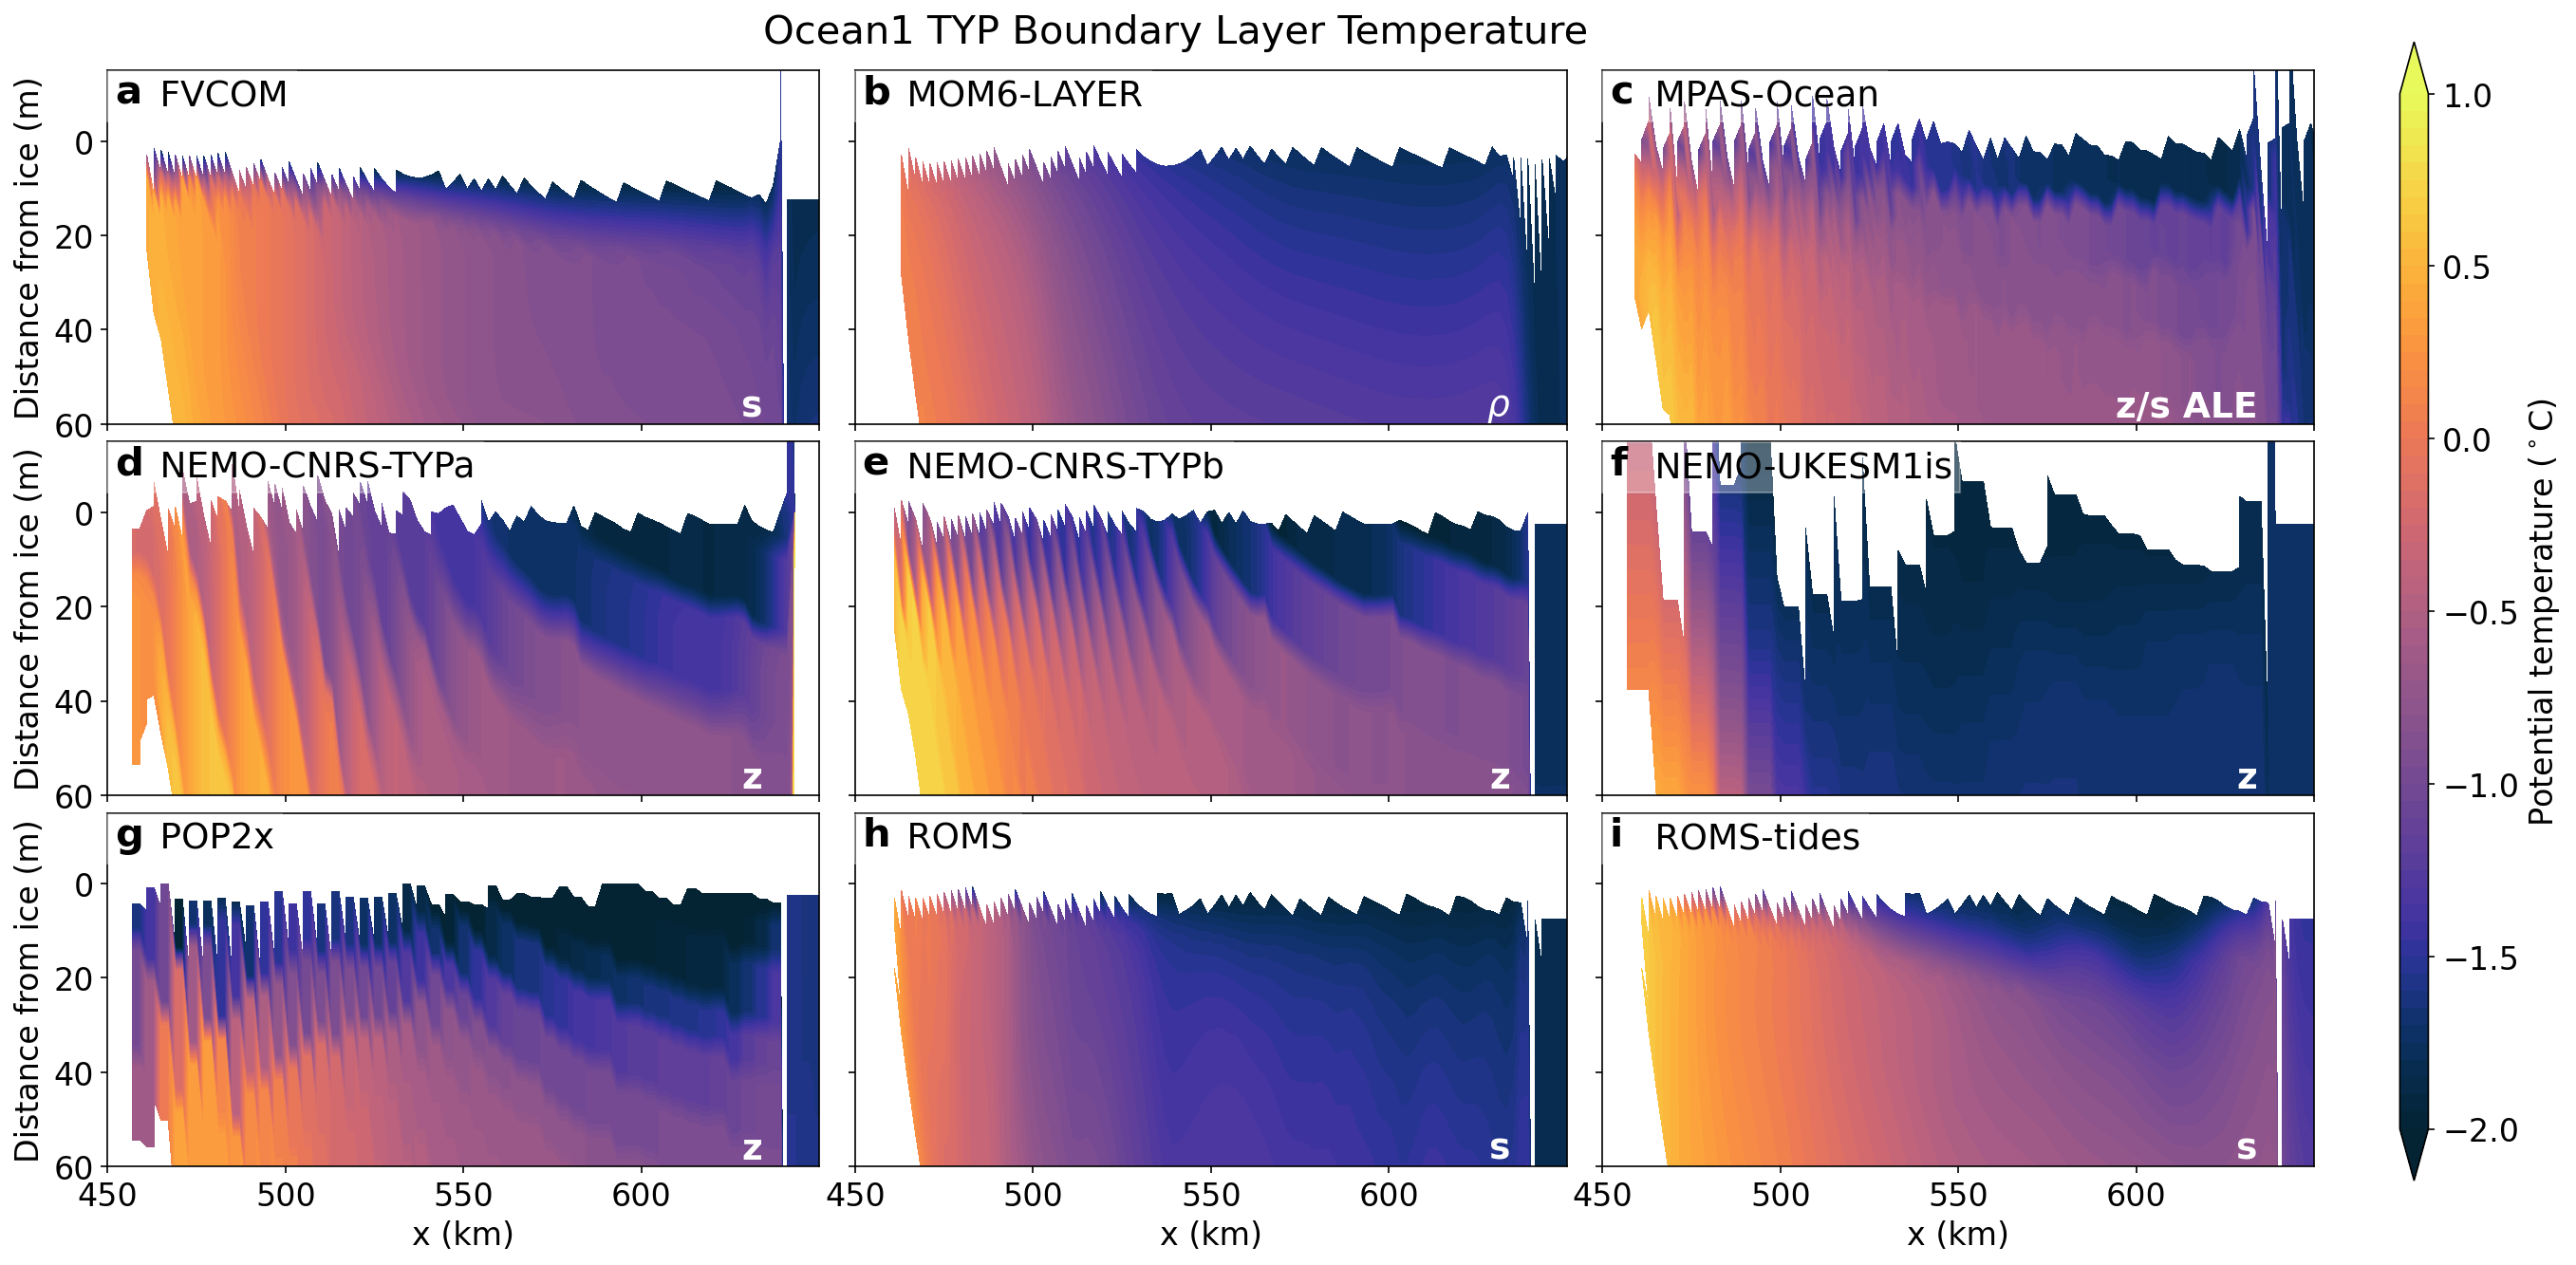

In [10]:
import matplotlib.gridspec as gridspec

expt = Ocean1_TYP
labels = get_labels(expt)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
ncols = int(np.ceil(length/3))

gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,10),facecolor='w',dpi = 150)


time = 240 #NOTE TO REMEMBER TO CHANGE THIS!!
for i in np.arange(length):
    # ax = plt.subplot(3,nrows,i+1)
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    var = data.temperatureXZ.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    var['nz'] = var.nz*5+2.5 # add depth (2.5,7.5 etc)
    var['nx'] = var.nx*2+321
    # find ice draft for this transect
    iceDraft = data.iceDraft.isel(ny=20)
    try:
        iceDraft = iceDraft.isel(nTime = np.arange(time-13,time)).mean('nTime')
        print('removing time dimension from '+labels[i]+' ice draft')
    except ValueError:
        print('no time dimension in ',labels[i],' ice draft')
        
    print('CHECK is this the correct transect location?')
    #some models have a flipped iceDraft...
    if iceDraft.isel(nx=100)>0:
        iceDraft = -iceDraft
        print('This model ',expt[i],' has an inverted iceDraft - flipping to match others')

        
    #reshape to be 2d field
    iceDraft = np.tile(iceDraft,(len(var.nz),1))

    # make proper transect x,z locations
    NZ = (np.tile(var.nz.values,[len(var.nx),1])).T
    NX = (np.tile(var.nx.values,[len(var.nz),1]))
    # mr<1e36 is to get rid of NaNs.
    #c = (var.where(var <1e36)).plot.contourf(cmap = cm.cm.thermal, levels = np.linspace(-2,1,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    c = plt.contourf(NX,np.nan_to_num(NZ+iceDraft,0),(var.where(var <1e36)),cmap = cm.cm.thermal, levels = np.linspace(-2,1,61),extend = 'both')
    # ls = (var.where(var <1e36)).plot.contour( levels = np.linspace(-2,1,21), colors = 'k', linewidths = 0.4)
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 18, transform=ax.transAxes, va='top',bbox=dict(facecolor='w', alpha=0.3,ec = 'w'))
    plt.text(0.01,0.99,alphabet[i], fontsize = 20, transform=ax.transAxes, fontweight='bold', va='top')
    # ax.grid()

        
    if (i==0) or (i==3) or (i==6):
        plt.ylabel('Distance from ice (m)',fontsize=16)
    else:
        plt.ylabel('')
        ax.set_yticklabels([])
    if i>=6:
        plt.xlabel('x (km)',fontsize=16)
        plt.xticks([450,500,550,600])
    else:
        plt.xlabel('')
        ax.set_xticklabels([])
    plt.ylim(60,-15)
    plt.xlim(450,650)
    plt.tick_params(labelsize=16)
    t = plt.text(0.92,0,vert_coord_type[i], fontsize = 18, transform=ax.transAxes, 
             fontweight='bold', va='bottom',color = 'w', ha = 'right')


cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(c, cax = cax)
cbar.ax.set_ylabel(r'Potential temperature ($^\circ $C)', fontsize = 16)
cbar.ax.set_yticks(np.arange(-2,1.1,0.5))
# cbar.add_lines(ls)
plt.tick_params(labelsize=16)

fig.suptitle('Ocean1 TYP Boundary Layer Temperature', y = 0.92,fontsize = 20);

no time dimension in  FVCOM  ice draft
CHECK is this the correct transect location?
no time dimension in  MOM6  ice draft
CHECK is this the correct transect location?
no time dimension in  MPAS-Ocean  ice draft
CHECK is this the correct transect location?
no time dimension in  NEMO-CNRS  ice draft
CHECK is this the correct transect location?
This model  NEMO-CNRS/Ocean0-2 TYP/TYPa/Ocean1_TYPa_NEMO-CNRS.nc  has an inverted iceDraft - flipping to match others
no time dimension in  NEMO-CNRS  ice draft
CHECK is this the correct transect location?
This model  NEMO-CNRS/Ocean0-2 TYP/TYPb/Ocean1_TYPb_NEMO-CNRS.nc  has an inverted iceDraft - flipping to match others
no time dimension in  NEMO-UKESM1is  ice draft
CHECK is this the correct transect location?
This model  NEMO-UKESM1is/Ocean0-2 TYP/Ocean1_TYP_NEMO-UKESM1is.nc  has an inverted iceDraft - flipping to match others
no time dimension in  POP2x  ice draft
CHECK is this the correct transect location?
removing time dimension from ROMSUTA

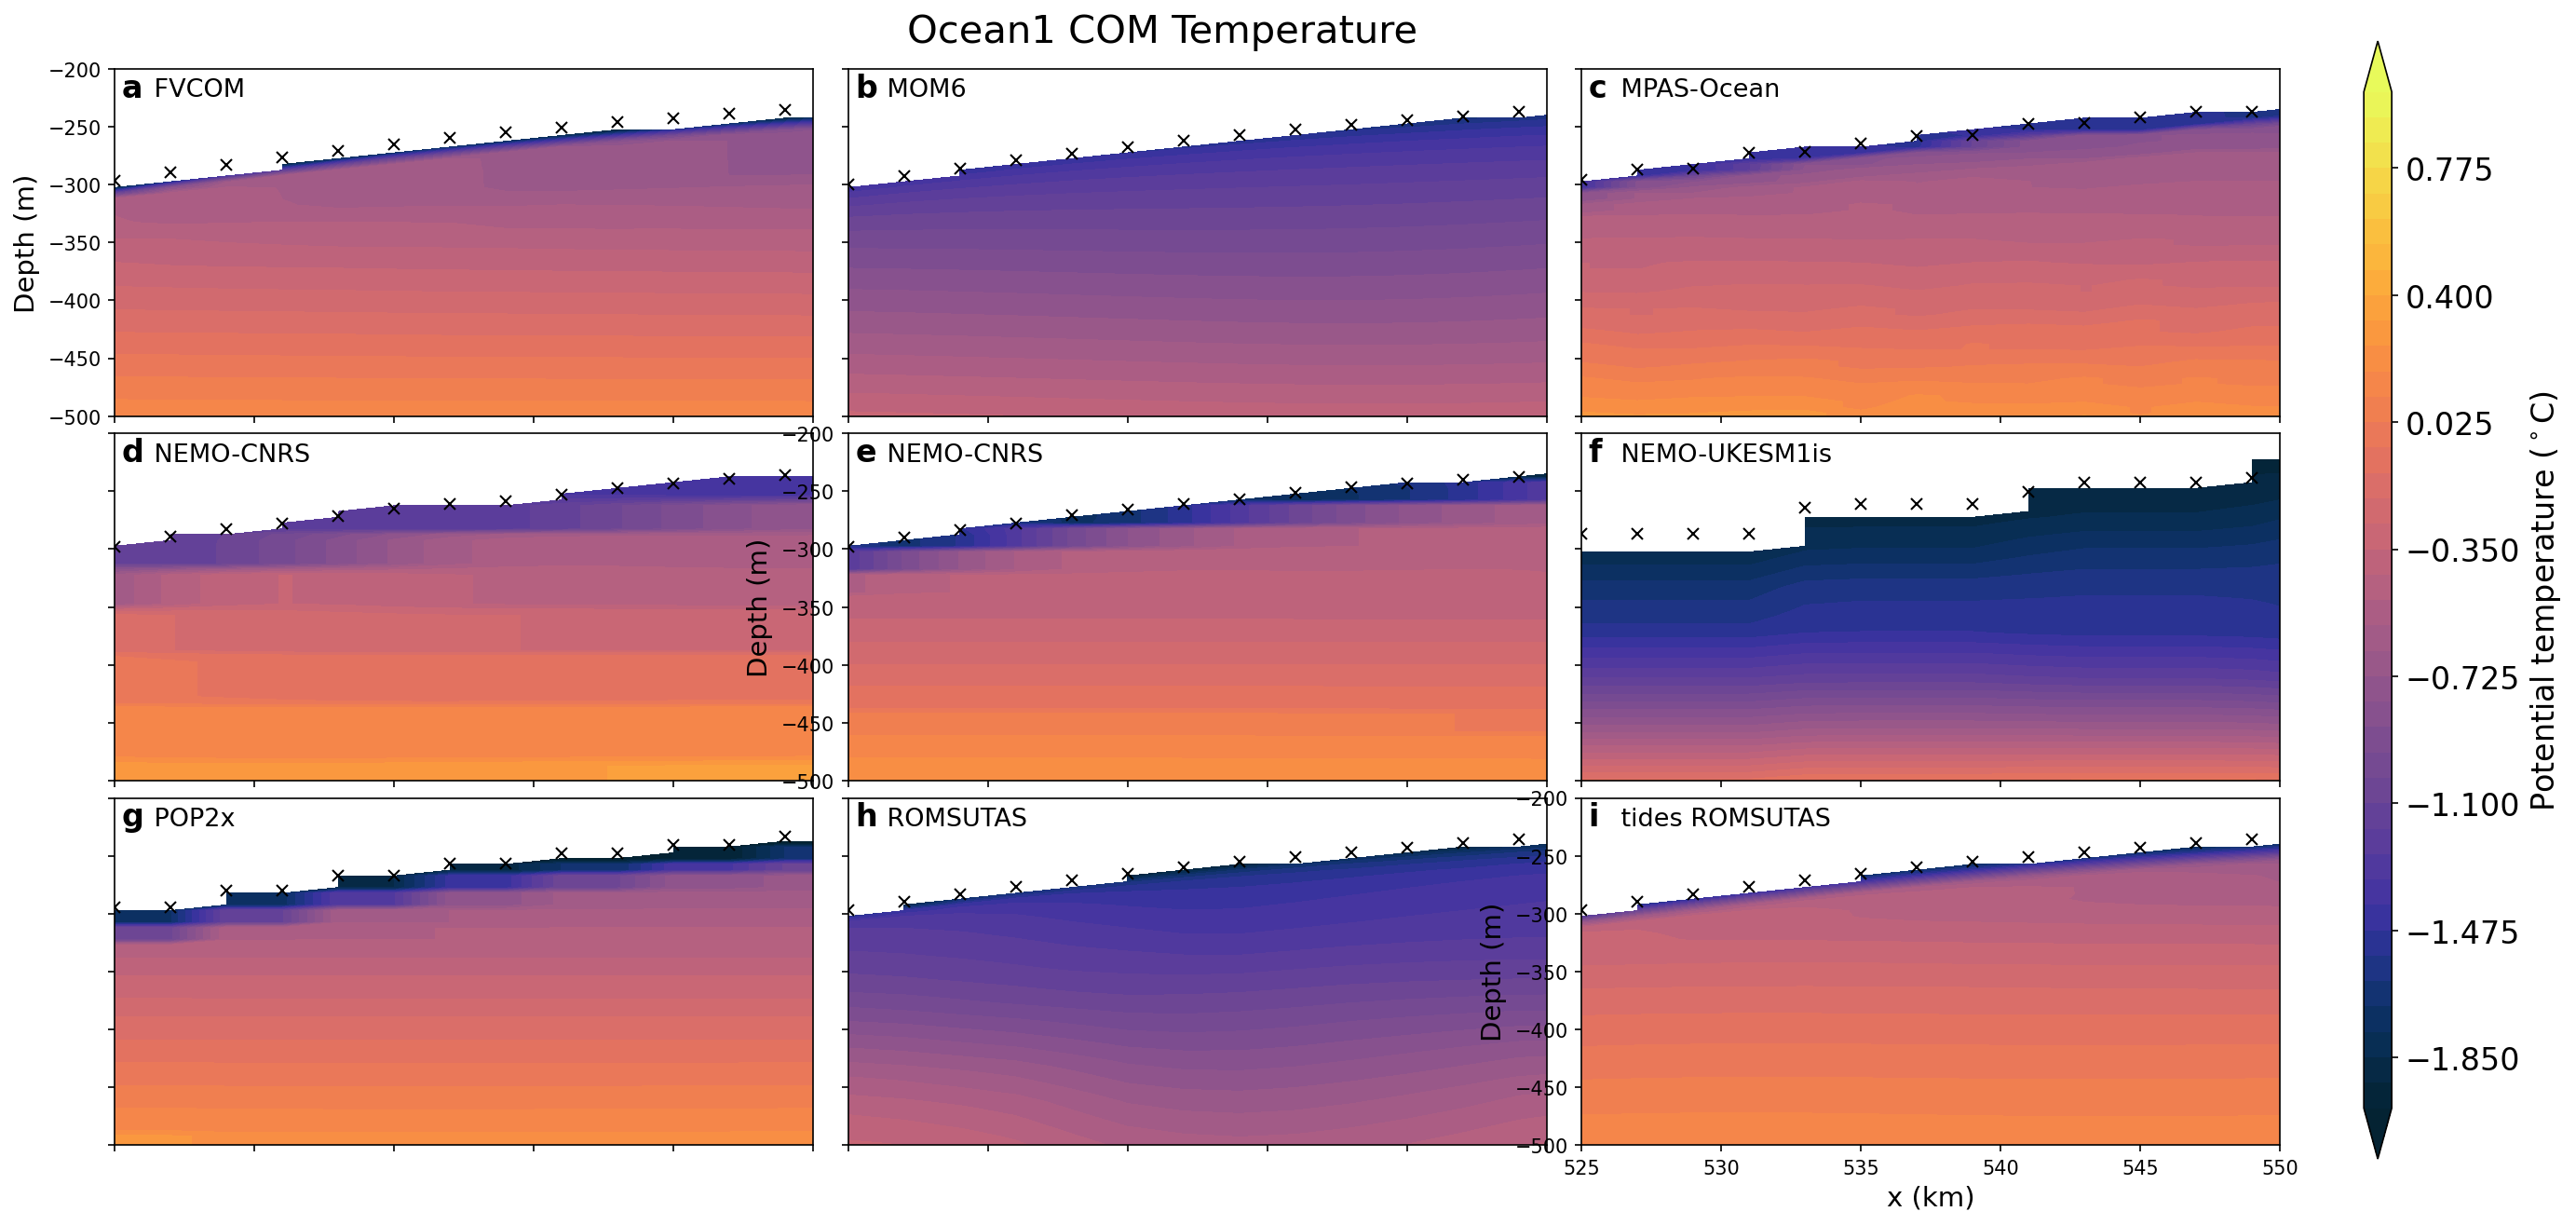

In [42]:
import matplotlib.gridspec as gridspec

expt = Ocean1_TYP
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
ncols = int(np.ceil(length/3))

gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,10),facecolor='w',dpi = 150)


time = 240 #NOTE TO REMEMBER TO CHANGE THIS!!
for i in np.arange(length):
    # ax = plt.subplot(3,nrows,i+1)
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    var = data.temperatureXZ.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    var['nz'] = var.nz*5+2.5 # add depth (2.5,7.5 etc)
    var['nx'] = var.nx*2+321
    # find ice draft for this transect
    iceDraft = data.iceDraft.isel(ny=20)
    try:
        iceDraft = iceDraft.isel(nTime = np.arange(time-13,time)).mean('nTime')
        print('removing time dimension from '+labels[i]+' ice draft')
    except ValueError:
        print('no time dimension in ',labels[i],' ice draft')
        
    print('CHECK is this the correct transect location?')
    #some models have a flipped iceDraft...
    if iceDraft.isel(nx=100)>0:
        iceDraft = -iceDraft
        print('This model ',expt[i],' has an inverted iceDraft - flipping to match others')

    #reshape to be 2d field
    iceDraft = np.tile(iceDraft,(len(var.nz),1))
    # make proper transect x,z locations
    NZ = (np.tile(var.nz.values,[len(var.nx),1])).T
    NX = (np.tile(var.nx.values,[len(var.nz),1]))
    # mr<1e36 is to get rid of NaNs.
    #c = (var.where(var <1e36)).plot.contourf(cmap = cm.cm.thermal, levels = np.linspace(-2,1,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    c = plt.contourf(NX,-(NZ),(var.where(var <1e36)),cmap = cm.cm.thermal, levels = np.linspace(-2,1,41),extend = 'both')
    # ls = (var.where(var <1e36)).plot.contour( levels = np.linspace(-2,1,21), colors = 'k', linewidths = 0.4)
    poi = plt.plot(NX[0,:],iceDraft[0,:],'kx')
    plt.text(0.01,0.99,alphabet[i], fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 13, transform=ax.transAxes, va='top')
    # ax.grid()

    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
        
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('Depth (m)',fontsize=14)
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)',fontsize=14)
    else:
        plt.xlabel('')
    plt.ylim(-500,-200)
    plt.xlim(525,550)


cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(c, cax = cax)
cbar.ax.set_ylabel(r'Potential temperature ($^\circ $C)', fontsize = 16)
# cbar.add_lines(ls)
plt.tick_params(labelsize=16)

fig.suptitle('Ocean1 COM Temperature', y=0.92, fontsize = 20);

no time dimension in  FVCOM  ice draft
CHECK is this the correct transect location?
no time dimension in  MOM6-LAYER  ice draft
CHECK is this the correct transect location?
no time dimension in  MPAS-Ocean  ice draft
CHECK is this the correct transect location?
no time dimension in  NEMO-CNRS-TYPa  ice draft
CHECK is this the correct transect location?
This model  NEMO-CNRS/Ocean0-2 TYP/TYPa/Ocean2_TYPa_NEMO-CNRS.nc  has an inverted iceDraft - flipping to match others
no time dimension in  NEMO-CNRS-TYPb  ice draft
CHECK is this the correct transect location?
This model  NEMO-CNRS/Ocean0-2 TYP/TYPb/Ocean2_TYPb_NEMO-CNRS.nc  has an inverted iceDraft - flipping to match others
no time dimension in  NEMO-UKESM1is  ice draft
CHECK is this the correct transect location?
This model  NEMO-UKESM1is/Ocean0-2 TYP/Ocean2_TYP_NEMO-UKESM1is.nc  has an inverted iceDraft - flipping to match others
no time dimension in  POP2x  ice draft
CHECK is this the correct transect location?
removing time dimens

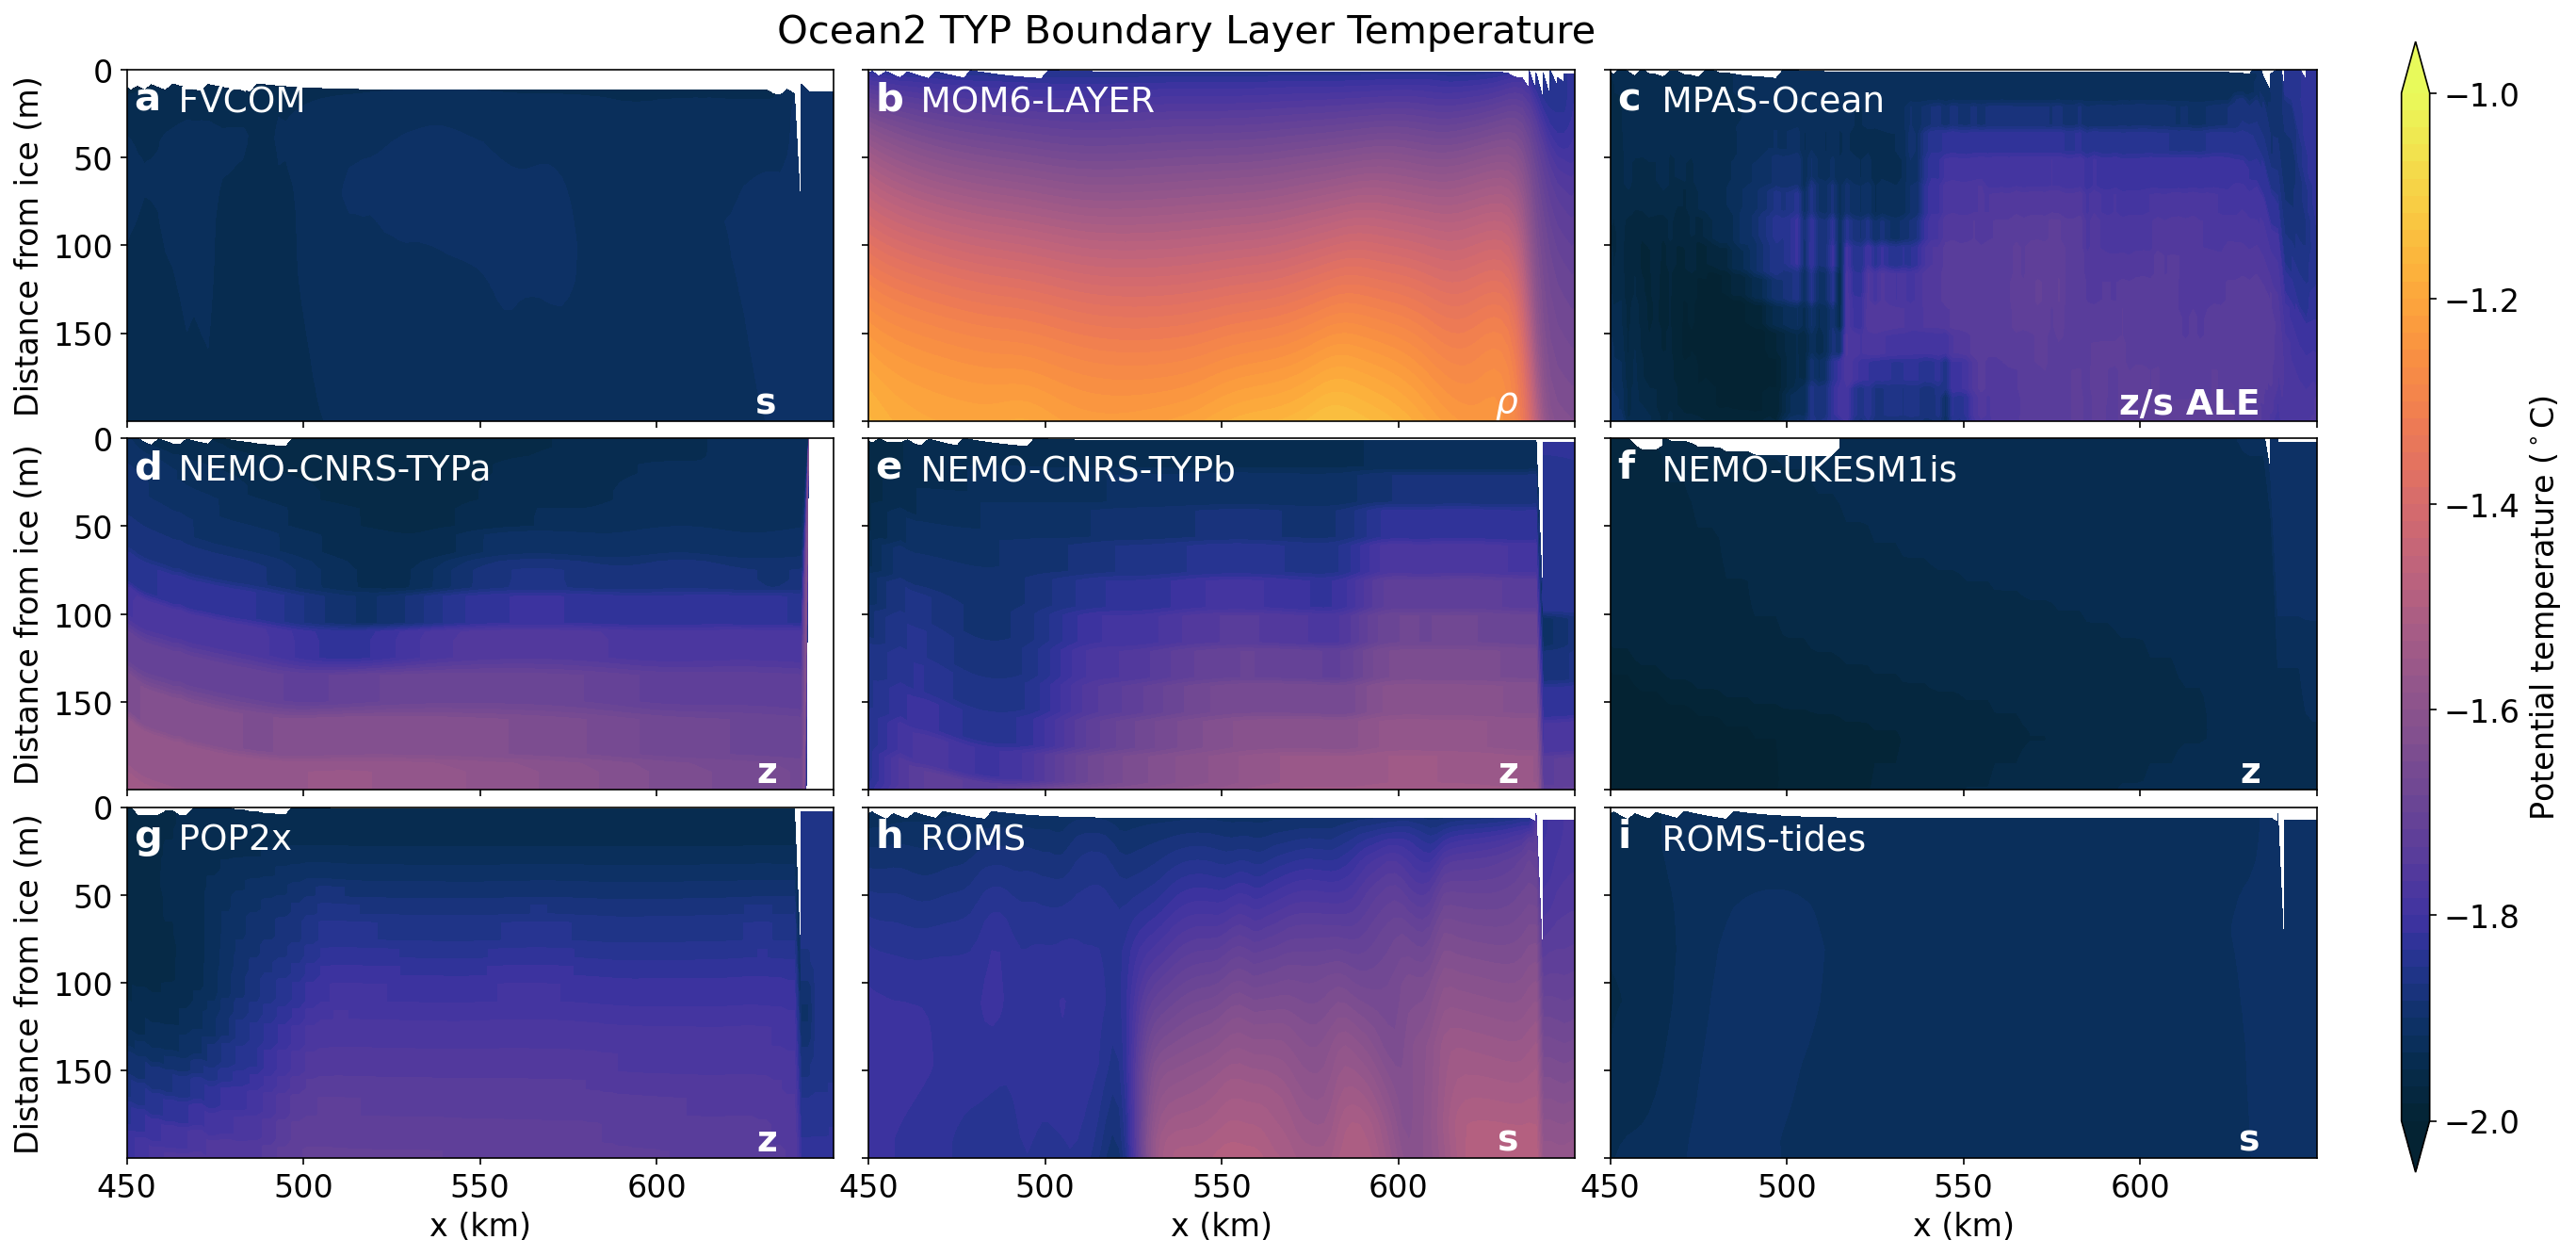

In [12]:
import matplotlib.gridspec as gridspec

expt = Ocean2_TYP
labels = get_labels(expt)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
ncols = int(np.ceil(length/3))

gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,10),facecolor='w',dpi = 150)


time = 240 #NOTE TO REMEMBER TO CHANGE THIS!!
for i in np.arange(length):
    # ax = plt.subplot(3,nrows,i+1)
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    var = data.temperatureXZ.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    var['nz'] = var.nz*5+2.5 # add depth (2.5,7.5 etc)
    var['nx'] = var.nx*2+321
    # find ice draft for this transect
    iceDraft = data.iceDraft.isel(ny=20)
    try:
        iceDraft = iceDraft.isel(nTime = np.arange(time-13,time)).mean('nTime')
        print('removing time dimension from '+labels[i]+' ice draft')
    except ValueError:
        print('no time dimension in ',labels[i],' ice draft')
        
    print('CHECK is this the correct transect location?')
    #some models have a flipped iceDraft...
    if iceDraft.isel(nx=100)>0:
        iceDraft = -iceDraft
        print('This model ',expt[i],' has an inverted iceDraft - flipping to match others')

    #reshape to be 2d field
    iceDraft = np.tile(iceDraft,(len(var.nz),1))
    # make proper transect x,z locations
    NZ = (np.tile(var.nz.values,[len(var.nx),1])).T
    NX = (np.tile(var.nx.values,[len(var.nz),1]))
    # mr<1e36 is to get rid of NaNs.
    #c = (var.where(var <1e36)).plot.contourf(cmap = cm.cm.thermal, levels = np.linspace(-2,1,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    c = plt.contourf(NX,np.nan_to_num(NZ+iceDraft,0),(var.where(var <1e36)),cmap = cm.cm.thermal, levels = np.linspace(-2,-1,61),extend = 'both')
    # ls = (var.where(var <1e36)).plot.contour( levels = np.linspace(-2,1,21), colors = 'k', linewidths = 0.4)
    plt.text(0.01,0.97,alphabet[i], fontsize = 20, transform=ax.transAxes, fontweight='bold', va='top',color = 'w')
    plt.text(0.01,0.955,'    '+labels[i], fontsize = 18, transform=ax.transAxes, va='top',color = 'w')
    # ax.grid()

    if (i==0) or (i==3) or (i==6):
        plt.ylabel('Distance from ice (m)',fontsize=16)
        plt.yticks([0,50,100,150])
    else:
        plt.ylabel('')
        ax.set_yticklabels([])
    if i>=6:
        plt.xlabel('x (km)',fontsize=16)
        plt.xticks([450,500,550,600])
    else:
        plt.xlabel('')
        ax.set_xticklabels([])
    plt.ylim(200,0)
    plt.xlim(450,650)
    plt.tick_params(labelsize=16)
    t = plt.text(0.92,0,vert_coord_type[i], fontsize = 18, transform=ax.transAxes, 
             fontweight='bold', va='bottom',color = 'w', ha = 'right')


cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(c, cax = cax)
cbar.ax.set_ylabel(r'Potential temperature ($^\circ $C)', fontsize = 16)
cbar.ax.set_yticks(np.arange(-2,-0.9,0.2))

# cbar.add_lines(ls)
plt.tick_params(labelsize=16)

fig.suptitle('Ocean2 TYP Boundary Layer Temperature', y = 0.92,fontsize = 20);